# Imports
We'll be manipulating tabular data and images, so let's import some helpful libraries

In [66]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.manifold import TSNE

%matplotlib inline
%config InlineBackend.figure_format='retina'

# Data and Utils
Let's load in the data for each 0xmon and write some helpful functions

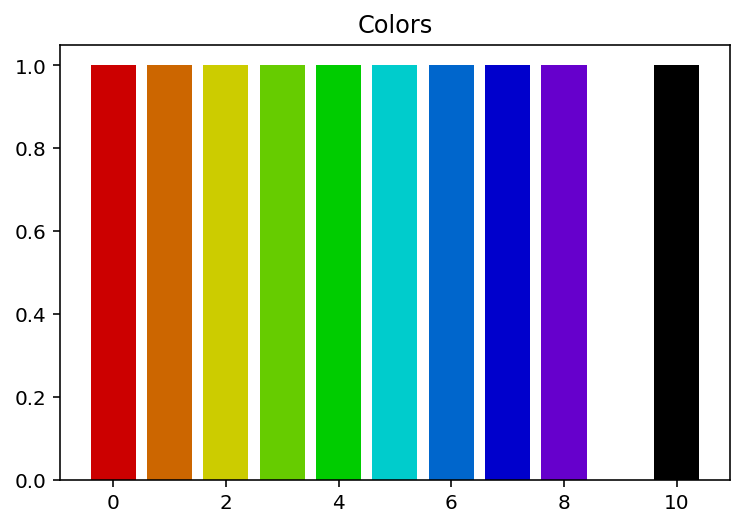

In [4]:
# loading our 0xmon data
data = pd.read_csv("monData.csv")

# In order to cluster, we'll need a smaller set of colors, formatted in RGBA 
# Feel free to change this to other colors for your own analysis, but leave black at the end
colors = np.array([[204,0,0,255],
          [204,102,0,255],
          [204,204,0,255],
          [102,204,0,255],
          [0,204,0,255],
          [0,204,204,255],
          [0,102,204,255],
          [0,0,204,255],
          [102,0,204,255],
          [255,255,255,255],
          # most of the image can be black, so we leave it last for easy removal later
          # (it'll make sense later, basically we'll be omitting the last column sometimes) 
          [0,0,0,255],])

# Display all of the colors we're using
plt.bar([i for i in range(len(colors))],[1 for i in range(len(colors))], color=colors/255)
plt.title("Colors")
plt.show()

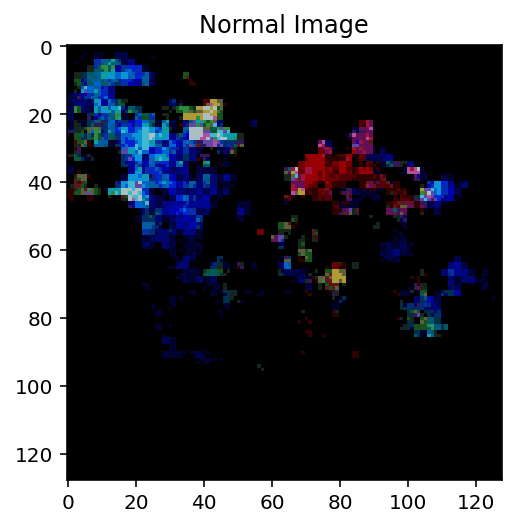

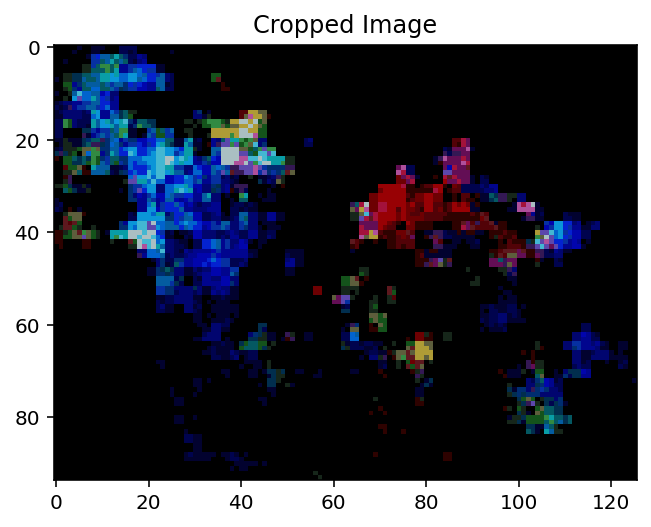

In [6]:
# Returns image data for a 0xmon
def get_img(i):
    return mpimg.imread('static/' + data.iloc[i]["Image"])

mon_index = 12
plt.imshow(get_img(mon_index))
plt.title("Normal Image")
plt.show()

# Get bounding box for an image (basically crop out the extra space)
def get_box(img):
    height = img.shape[0]
    width = img.shape[1]
    top = None
    bot = None
    left = None
    right = None
    for i in range(height):
        for j in range(width):
            if (np.sum(img[i][j][0:3]) != 0) and (top == None):
                top = i         
    for i in reversed(range(height)):
        for j in range(width):
            if (np.sum(img[i][j][0:3]) != 0) and (bot == None):
                bot = i+1     
    for i in range(width):
        for j in range(height):
            if (np.sum(img[j][i][0:3]) != 0) and (left == None):
                left = i        
    for i in reversed(range(width)):
        for j in range(height):
            if (np.sum(img[j][i][0:3]) != 0) and (right == None):
                right = i+1
    return (top, bot, left, right)

def crop_img(img):
    top,bot,left,right = get_box(img)
    cropped_img = img[top:bot, left:right]
    return cropped_img

plt.imshow(crop_img(get_img(mon_index)))
plt.title("Cropped Image")
plt.show()

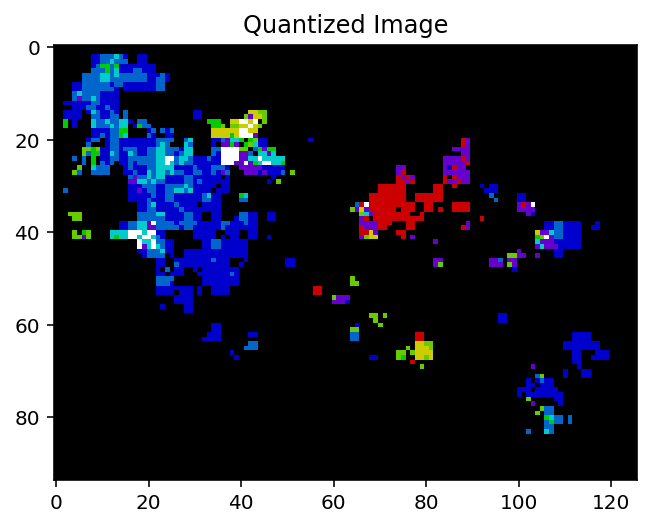

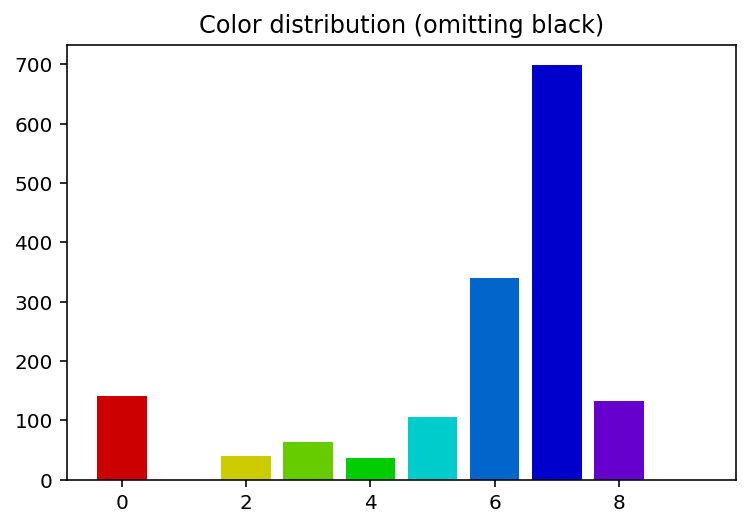

In [26]:
# Returns the closest color between `color` and the list of colors we have
def closest_color_and_index(color):
    closest_index = 0
    closest_color = colors[0]
    # max color difference is between (0,0,0,255) and (255,255,255,255) 
    diff = 3*255*255 
    for i in range(len(colors)):
        c = colors[i]
        curr_diff = np.linalg.norm(c - color)
        if curr_diff < diff:
            diff = curr_diff
            closest_color = c
            closest_index = i
    return (closest_color, closest_index)

# Convert all pixels into one of the specified colors above
# Returns both a quantized image and a vector of how many of each color was used
def quantize(img):
    quantized_img = []
    quantized_counts = np.zeros((len(colors)))
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            (closest_color, closest_index) = closest_color_and_index(img[x][y])
            quantized_img.append(closest_color)
            quantized_counts[closest_index] += 1
    return (np.array(quantized_img).reshape(img.shape), quantized_counts)

mon_index = 12
quantized_img, quantized_counts = quantize(crop_img(get_img(mon_index)))
plt.imshow(quantized_img)
plt.title("Quantized Image")
plt.show()

plt.bar([i for i in range(len(colors))][0:-1], quantized_counts.ravel()[0:-1], color=colors/255)
plt.title("Color distribution (omitting black)")
plt.show()

# Analyzing the 0xmons
Now that we have all the pre-requisites, we can start processing our data

In [27]:
# Note: will take a while to run
discretized_mons = []
for i in range(len(data)):
    quantized_img, quantized_counts = quantize(crop_img(get_img(i)))
    discretized_mons.append(quantized_counts)
discretized_mons = np.array(discretized_mons)

# Convert all vectors to be normalized form (sum of each vector is 1)
normalized_discretized_mons = discretized_mons/discretized_mons.sum(axis=1).reshape(-1, 1)

In [80]:
# Calculate the most frequent color (outside black) for each 0xmon
# we'll use this for the scatterplots below as a rough indication of
# each 0xmon's "class"
data_color_class = np.array([colors[i] for i in np.argmax(discretized_mons[:, 0:-1], axis=1)])/255

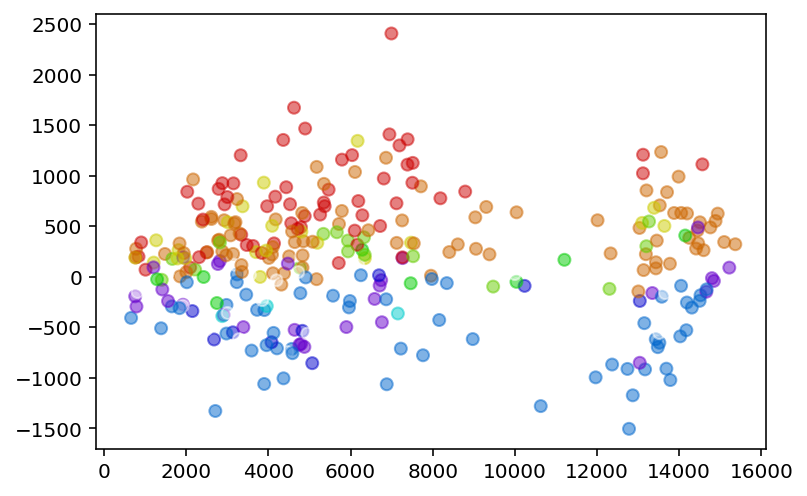

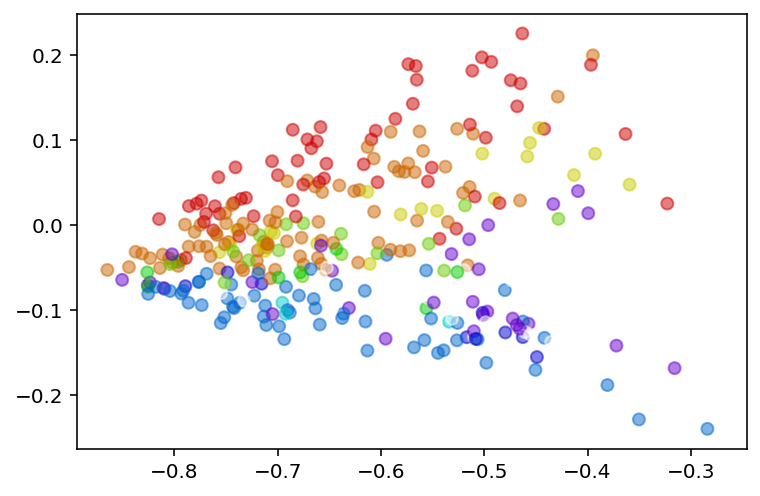

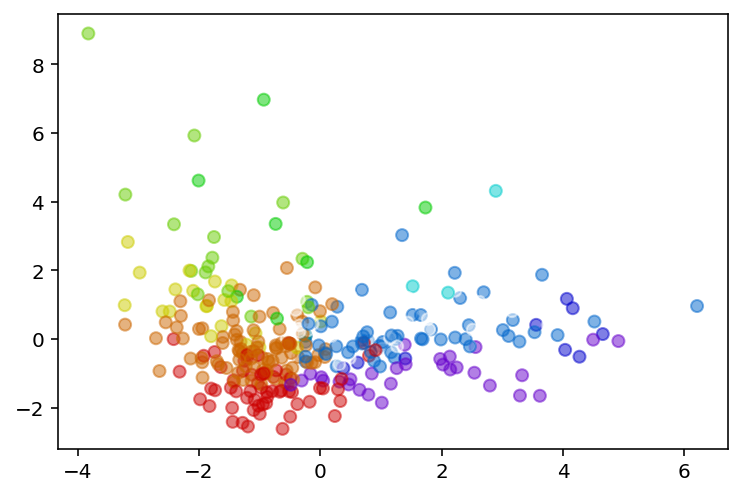

In [95]:
# Project into just two dimensions using PCA

# For raw data
pca = PCA(n_components=2).fit(discretized_mons)
reduced_mons_1 = discretized_mons.dot(pca.components_.T)
plt.scatter(reduced_mons_1[:,0], reduced_mons_1[:,1], alpha=0.5, c=data_color_class)
plt.show()

# For normalized data 
pca = PCA(n_components=2).fit(normalized_discretized_mons)
reduced_mons_2 = normalized_discretized_mons.dot(pca.components_.T)
plt.scatter(reduced_mons_2[:,0], reduced_mons_2[:,1], alpha=0.5, c=data_color_class)
plt.show()

# For StandardScaled data (subtracted mean, then divided by std for each feature)
scaler = preprocessing.StandardScaler().fit(normalized_discretized_mons)
scaled_mons = scaler.transform(normalized_discretized_mons)
pca = PCA(n_components=2).fit(scaled_mons)
reduced_mons_3 = scaled_mons.dot(pca.components_.T)
plt.scatter(reduced_mons_3[:,0], reduced_mons_3[:,1], alpha=0.5, c=data_color_class)
plt.show()

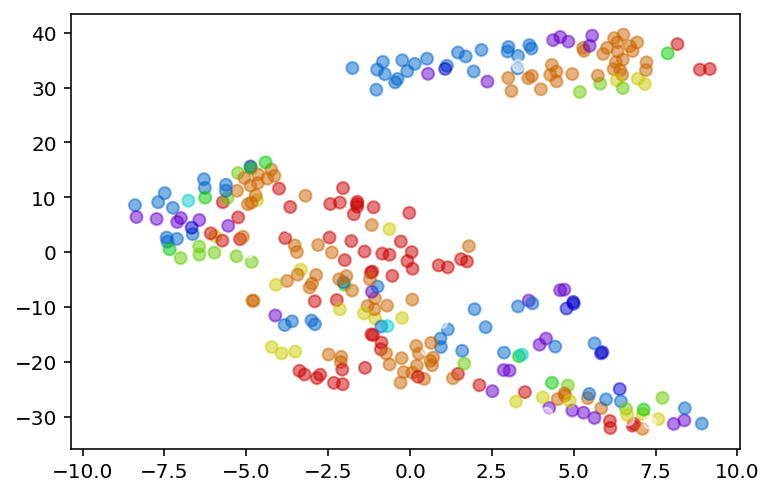

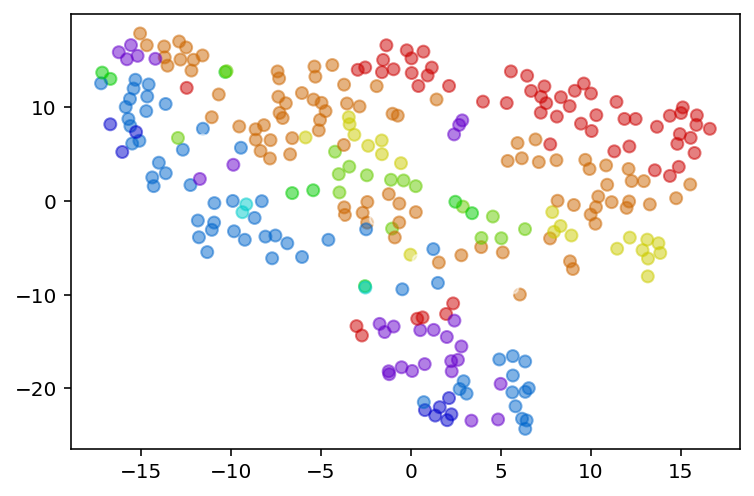

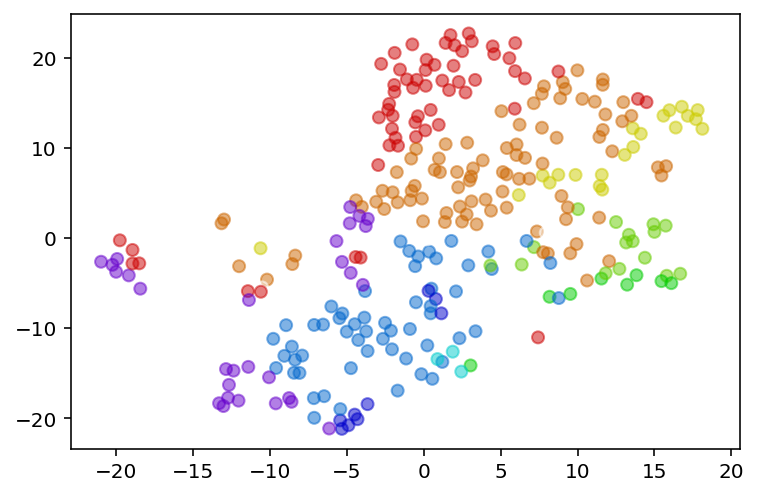

In [83]:
# Project data into two dimensions using TSNE

tsne = TSNE(n_components=2, random_state=0)

reduced_mons_4 = tsne.fit_transform(discretized_mons)
plt.scatter(reduced_mons_4[:,0], reduced_mons_4[:,1], alpha=0.5, c=data_color_class)
plt.show()

reduced_mons_5 = tsne.fit_transform(normalized_discretized_mons)
plt.scatter(reduced_mons_5[:,0], reduced_mons_5[:,1], alpha=0.5, c=data_color_class)
plt.show()

reduced_mons_6 = tsne.fit_transform(scaled_mons)
plt.scatter(reduced_mons_6[:,0], reduced_mons_6[:,1], alpha=0.5, c=data_color_class)
plt.show()

# Saving for interaction
Now we'll save some of these `reduced_mons` as `.json` files so we can view them on the 0xmons site for more exploration.

In [87]:
# reduced_mons_6 looks like it has very good color separation
df = pd.DataFrame(reduced_mons_6, columns=["x", "y"])

with open("reducedMons6.json", "w") as f:
    df.to_json(f, orient="records")

In [112]:
# reduced_mons_3 also looks like it has fairly good color separation
df = pd.DataFrame(reduced_mons_3, columns=["x", "y"])

with open("reducedMons3.json", "w") as f:
    df.to_json(f, orient="records")